<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/Comodgan_hand_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoModGans with Hand-painted mask

Note that CoModGans takes only 512x512 images. Better convert them before

In [1]:
#Imports

#!pip install wget --quiet

import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
#import wget
from shutil import copyfile
import shutil

import cv2
from google.colab.patches import cv2_imshow

Mask drawing code

In [2]:
print('\n> Init mask-drawing code')

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Init mask-drawing code


Upload image from PC

In [26]:
from google.colab import files
% cd /content/
# Create directory
upload_folder = './data_for_prediction'
if os.path.isdir(upload_folder):  #if folder already exist, delete it
    shutil.rmtree(upload_folder, ignore_errors=True)
else:    
    os.mkdir(upload_folder)


# Upload images and copy to 'data for prediction'
uploaded = files.upload()
for fname  in uploaded.keys():
  dst_path = os.path.join(upload_folder, fname )
  print(f'moved {fname } to {dst_path}')
  shutil.move(fname , dst_path)

fname = f'./data_for_prediction/{fname}'
img = cv2.imread(fname) 

/content


Saving escher_straightened_0.jpg_512 to escher_straightened_0.jpg_512
moved escher_straightened_0.jpg_512 to ./data_for_prediction/escher_straightened_0.jpg_512


FileNotFoundError: ignored

### Call the drawing function

Draw a Mask, Press Finish, Wait for Inpainting

Original and Mask are saved on folder 'data_for_prediction'


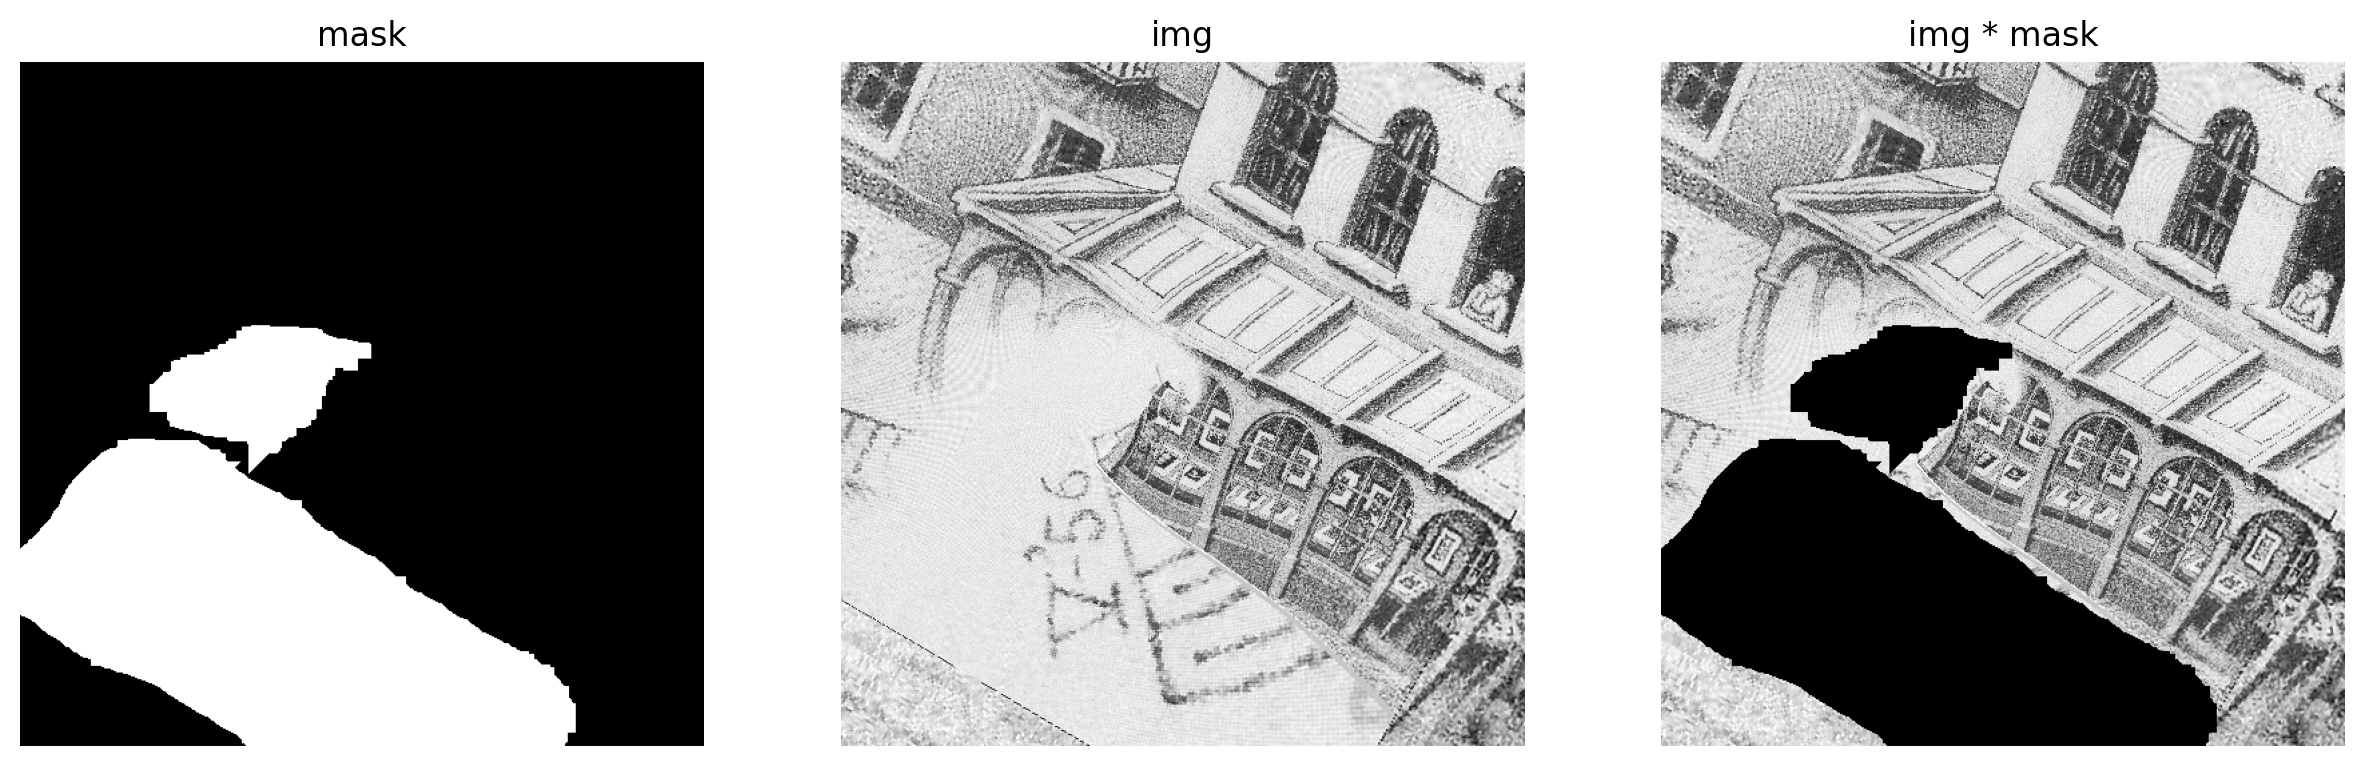

In [29]:
#Mask drawing function
image64 = base64.b64encode(open(fname, 'rb').read()) #encoding images as text, this is a trick to manipulate the image better.
image64 = image64.decode('utf-8')
pencil_width = 0.04*img.shape[1]
draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=pencil_width)


#Show a masked image and save a mask
import matplotlib.pyplot as plt #it uses this garbage to read images and convert to arrays, instead of CV2, wrong choice of library
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])

mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')

plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray') #save on 'data_for_prediction' folder

plt.subplot(132)
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
combined_img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*img) #combine the 3 together (input, mask and result)

_=plt.imshow(combined_img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

### CoModGan

Switch to tensorflow 1.x

In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
#!nvidia-smi #to check CUDA drivers and config

Clone the repo

In [33]:
print('\n> Changing the dir to:')
% cd /content/
!git clone https://github.com/zsyzzsoft/co-mod-gan.git
%cd co-mod-gan/


> Changing the dir to:
/content
fatal: destination path 'co-mod-gan' already exists and is not an empty directory.
/content/co-mod-gan


Download the model, copy the id from the drive link. 

Example: The ascii after folders/ and before ? in the below link: https://drive.google.com/drive/folders/1tpcwAr2aSNLouoBdeQuW2fCL8v1kAVhS?usp=sharing

In [32]:
!gdown --id 19EReeIpTqSrO9QomJ49XVYNHGKxkFL1K

Downloading...
From: https://drive.google.com/uc?id=19EReeIpTqSrO9QomJ49XVYNHGKxkFL1K
To: /content/network-snapshot-050060.pkl
100% 760M/760M [00:03<00:00, 212MB/s]


Adding the input image and mask to imgs/.

The output will be saved as output.jpg

In [30]:
# Copy images to the co-mod-gan folder
src  = '/content/data_for_prediction'
dest = '/content/co-mod-gan/imgs'

for filename in os.listdir(src):
    shutil. copy ( src + '/'+ filename , dest ) #copy both files
    if 'mask' in filename:
       mask_file = filename # save the masked file name for later
    else:
       image_file = filename #there are only 2 files on the LaMA folder.  

print('images copied to co-mod-gan/imgs folder! yes!')

# ***** mask color inversion ***************************************************************************
# The part of the image that has to be predicted by the model should be in black and the rest in white
# LaMa uses the reverse convention
src = '/content/co-mod-gan/imgs'
#convert mask
img = cv2.imread(src + '/' + mask_file) # bitwise function needs img as array # use previously saved name    
cv2.imwrite(dest + '/' + mask_file, cv2.bitwise_not(img)) #operations are not done -in place - we need to go back from array to image

print('mask converted ! refresh folder! yes!')

images copied to co-mod-gan/imgs folder! yes!
mask converted ! refresh folder! yes!


Resize input image and mask (if needed)

In [10]:
'''
#Co-Mod-Gans needs 512*512 images - Note that this resizing will distort the image!
#Resize input image

src = '/content/co-mod-gan/imgs'
img = cv2.imread(src + '/' + image_file) # resize function needs img as array 
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_LINEAR) 
cv2.imwrite(dest + '/' + image_file, img) #operations are not done -in place - we need to go back from array to image
#Resize mask
img = cv2.imread(src + '/' + mask_file) # resize function needs img as array 
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_LINEAR) 
cv2.imwrite(dest + '/' +mask_file, img) #operations are not done -in place - we need to go back from array to image

print('images resized! refresh folder! yes!')
'''

"\n#Co-Mod-Gans needs 512*512 images - Note that this resizing will distort the image!\n#Resize input image\n\nsrc = '/content/co-mod-gan/imgs'\nimg = cv2.imread(src + '/' + image_file) # resize function needs img as array \nimg = cv2.resize(img, (512,512), interpolation = cv2.INTER_LINEAR) \ncv2.imwrite(dest + '/' + image_file, img) #operations are not done -in place - we need to go back from array to image\n#Resize mask\nimg = cv2.imread(src + '/' + mask_file) # resize function needs img as array \nimg = cv2.resize(img, (512,512), interpolation = cv2.INTER_LINEAR) \ncv2.imwrite(dest + '/' +mask_file, img) #operations are not done -in place - we need to go back from array to image\n\nprint('images resized! refresh folder! yes!')\n"

In [48]:
test2.shape

(512, 512)

#### Running CoModGans

In the below code -c is for the model, -i is for the input image path, -m is for mask and -o is for path of output

In [50]:
# INSIDE THE SCRIPT run_generator.py (in CoModGan)


#LINE9 is WRONG::
#import PIL.Image
#test2 = np.asarray(PIL.Image.open(input_image))
#test2.shape # == (512,512) don't know why, it is missing the third channel

# THIS IS THE RIGHT CODE
#test= cv2.imread(input_image).transpose([2, 0, 1])
#test.shape # == (52,512,3)

SyntaxError: ignored

In [35]:
#use previously saved file name
input_image = 'imgs/'+ image_file
input_mask = 'imgs/'+ mask_file
output = 'imgs/output.jpg'

!python run_generator.py -c "/content/co-mod-gan/network-snapshot-050060.pkl" -i $input_image -m $input_mask -o $output

print('done! refresh co-mod-gan/imgs folder and look for output.jpg!')


Traceback (most recent call last):
  File "run_generator.py", line 34, in <module>
    main()
  File "run_generator.py", line 31, in main
    generate(**vars(args))
  File "run_generator.py", line 9, in generate
    real = np.asarray(PIL.Image.open(image)).transpose([2, 0, 1])
ValueError: axes don't match array
done! refresh co-mod-gan/imgs folder and look for output.jpg!


In [12]:
#Download file to disk!
files.download( '/content/co-mod-gan/imgs/output.jpg' ) 
print('done)')

FileNotFoundError: ignored